# ASL ETH FLIR: Thermal Infrared Dataset

Follow this notebook to prepare this dataset.

**Description**
- This dataset contains 4381 thermal infrared images containing humans, a cat, a horse and 2418 background images (no annotations). We provide manually annotated ground truth for all humans, cat and horse. The dataset is divided into 8 sequences and contains both 16bit (may appear black on most screens) images as well as the downsampled 8bit images. The uniform sampling rate allows the usage of tracking algorithms.


**Annotations**
- annotations are stored in txt file per camera sequence.
- bounding boxes are in xywh format

**Table of content:**

0. Init - imports and data download
1. Data transformation
2. Dataset visualization

Download dataset from [https://projects.asl.ethz.ch/datasets/doku.php?id=ir:iricra2014](https://projects.asl.ethz.ch/datasets/doku.php?id=ir:iricra2014) and prepare directories to use. Unpack .zip file to `data/source/asl_eth_flir` and prepare 8 directories listed below (other should be deleted).

Arrange directory according to the schema shown below:
```
data
└───source
    └───asl_eth_flir
        ├───ETHZ-ASL
        │   ├───16bit
        │   ├───8bit
        │   └───annotation
        ├───Sempach-10
        │   ├───16bit
        │   ├───8bit
        │   └───annotation
        ├───Sempach-11
        │   ├───16bit
        │   ├───8bit
        │   └───annotation
        ├───Sempach-12
        │   ├───16bit
        │   ├───8bit
        │   └───annotation
        ├───Sempach-6
        │   ├───16bit
        │   ├───8bit
        │   └───annotation
        ├───Sempach-7
        │   ├───16bit
        │   ├───8bit
        │   └───annotation
        ├───Sempach-8
        │   ├───16bit
        │   ├───8bit
        │   └───annotation
        └───Sempach-9
            ├───16bit
            ├───8bit
            └───annotation
```

We will use only 8-bit images.


In [1]:
import random
from random import sample
import pandas as pd
import numpy as np
import os
import re
import cv2
import shutil
from pathlib import Path
from typing import Dict

from prj_utils.consts import ROOT_DIR
from data_processing.image_processing import get_number_of_objects_stats, copy_annotated_images
from data_processing.image_processing import plot_xywhn_annotated_image_from_file
from data_processing.annotation_processing import from_xywh_to_xywhn_format

file_obj_separator = '-----------------------------------'
DATASET_PATH = f'{ROOT_DIR}/data/source/asl_eth_flir'
PROCESSED_DATASET_PATH = f'{ROOT_DIR}/data/processed/asl_eth_flir'
PROCESSED_DATASET_TMP_PATH = f'{ROOT_DIR}/data/processed/asl_eth_flir/tmp_jpg'
PROCESSED_DATASET_IMG_TMP_PATH = f'{ROOT_DIR}/data/processed/asl_eth_flir/tmp'
HEADER = ['class', 'x_left', 'y_top', 'width', 'height']
TRAIN_PROCESSED_DIR = f'{ROOT_DIR}/data/processed/asl_eth_flir/train'

Path(f'{PROCESSED_DATASET_TMP_PATH}/labels').mkdir(parents=True, exist_ok=True)
Path(f'{PROCESSED_DATASET_TMP_PATH}/images').mkdir(parents=True, exist_ok=True)
Path(f'{PROCESSED_DATASET_TMP_PATH}/annotations').mkdir(parents=True, exist_ok=True)
Path(f'{PROCESSED_DATASET_IMG_TMP_PATH}/images').mkdir(parents=True, exist_ok=True)
os.makedirs(f'{PROCESSED_DATASET_PATH}/train/labels', exist_ok=True)
os.makedirs(f'{PROCESSED_DATASET_PATH}/validate/labels', exist_ok=True)
os.makedirs(f'{PROCESSED_DATASET_PATH}/test/labels', exist_ok=True)
os.makedirs(f'{PROCESSED_DATASET_PATH}/train/images', exist_ok=True)
os.makedirs(f'{PROCESSED_DATASET_PATH}/validate/images', exist_ok=True)
os.makedirs(f'{PROCESSED_DATASET_PATH}/test/images', exist_ok=True)

dirs = os.listdir(DATASET_PATH)

In [2]:
def file_object_text_to_label_dict(text: str) -> Dict[int, str]:
    obj_data = text.split('\n')
    obj_info = obj_data[0].split(' ')

    # Extract bounding box list from text
    bbox_positions = obj_data[1]
    if bbox_positions[4] == '=':
        xywh_bbox_positions = bbox_positions[6:-3].strip().split(';')
    else:
        raise Exception('Incorrect bbox format.')

    # Extract label from text
    label = re.search(r"lbl='([a-zA-Z_]*)'", obj_info[0]).group(1)
    if label not in ['person', 'human', 'object', 'human_child']:
        return {}

    # Prepare annotations
    start_range = int(obj_info[1][4:])
    end_range = int(obj_info[2][4:]) + 1
    labels: Dict[int: str] = {}
    assert len(xywh_bbox_positions) == end_range - start_range
    for i, img_number in enumerate(range(start_range, end_range)):
        bbox = xywh_bbox_positions[i].strip()
        assert bbox.count(' ') == 3
        labels[img_number] = f'0 {bbox}'

    return labels

## 1. Data transformation
- Transform from txt per dir to labels per image
- Convert data to YOLO format
- Split dataset to train. validate, test

### 1.1 Transform from txt per dataset dir to labels per image

In [3]:
for dir_name in dirs:
    with open(f'{DATASET_PATH}/{dir_name}/annotation/{dir_name}.txt', 'r') as file:
        data = file.read()
        objects_data = data.split(file_obj_separator)
        assert objects_data[0].startswith('% vbb version')

        for obj_txt_data in objects_data[1:]:
            obj_labels = file_object_text_to_label_dict(obj_txt_data.strip())
            for img_number, labels in obj_labels.items():
                # Save labels
                filename = f'{PROCESSED_DATASET_TMP_PATH}/annotations/{dir_name}_{img_number}.txt'
                pd.DataFrame([labels.split()]).to_csv(filename, mode='a', header=False, index=False)

                # Save images
                src = f'{DATASET_PATH}/{dir_name}/8bit/{img_number}.png'
                dst = f'{PROCESSED_DATASET_IMG_TMP_PATH}/images/{dir_name}_{img_number}.png'
                shutil.copyfile(src, dst)

### 1.2 Convert to jpg

In [4]:
filenames = os.listdir(f'{PROCESSED_DATASET_IMG_TMP_PATH}/images')
for filename in filenames:
    filepath = f'{PROCESSED_DATASET_IMG_TMP_PATH}/images/{filename}'
    filepath_jpg = f'{PROCESSED_DATASET_TMP_PATH}/images/{filename}'

    img = cv2.imread(filepath)
    cv2.imwrite(filepath_jpg.split('.')[0] + '.jpg', img)

shutil.rmtree(PROCESSED_DATASET_IMG_TMP_PATH)

### 1.3 Convert data to YOLO format

In [5]:
from_xywh_to_xywhn_format(f'{PROCESSED_DATASET_TMP_PATH}/annotations',
                          f'{PROCESSED_DATASET_TMP_PATH}/labels',
                          f'{PROCESSED_DATASET_TMP_PATH}/images',
                          HEADER)

### 1.4 Split dataset

In [6]:
random.seed(1)
np.random.seed(1)
filenames = os.listdir(f'{PROCESSED_DATASET_TMP_PATH}/labels')
split1 = int(0.6 * len(filenames))
split2 = int(0.8 * len(filenames))

np.random.shuffle(filenames)

train_filenames = filenames[:split1]
val_filenames = filenames[split1:split2]
test_filenames = filenames[split2:]

for filename in train_filenames:
    shutil.copy(f'{PROCESSED_DATASET_TMP_PATH}/labels/{filename}', f'{PROCESSED_DATASET_PATH}/train/labels')
copy_annotated_images(f'{PROCESSED_DATASET_TMP_PATH}/images',
                      f'{PROCESSED_DATASET_PATH}/train/labels',
                      f'{PROCESSED_DATASET_PATH}/train/images')

for filename in val_filenames:
    shutil.copy(f'{PROCESSED_DATASET_TMP_PATH}/labels/{filename}', f'{PROCESSED_DATASET_PATH}/validate/labels')
copy_annotated_images(f'{PROCESSED_DATASET_TMP_PATH}/images',
                      f'{PROCESSED_DATASET_PATH}/validate/labels',
                      f'{PROCESSED_DATASET_PATH}/validate/images')

for filename in test_filenames:
    shutil.copy(f'{PROCESSED_DATASET_TMP_PATH}/labels/{filename}', f'{PROCESSED_DATASET_PATH}/test/labels')
copy_annotated_images(f'{PROCESSED_DATASET_TMP_PATH}/images',
                      f'{PROCESSED_DATASET_PATH}/test/labels',
                      f'{PROCESSED_DATASET_PATH}/test/images')
shutil.rmtree(PROCESSED_DATASET_TMP_PATH)

After processing dataset should look like this:
```
data
└───processed
    └───asl_eth_flir
        ├───test
        │   ├───images
        │   └───labels
        ├───train
        │   ├───images
        │   └───labels
        └───validate
            ├───images
            └───labels
```

## 2. Dataset visualization
- Dataset stats
- Data annotation visualization - example images

### 2.1 Dataset stats
Show stats by:
- number of objects

array([[<AxesSubplot:title={'center':'number of objects'}>]], dtype=object)

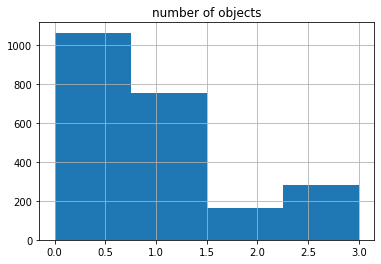

In [7]:

# By number of objects
max_people_limit = 4
number_of_people_stats = get_number_of_objects_stats(TRAIN_PROCESSED_DIR + '/labels/')
number_of_people_stats[number_of_people_stats['number of objects'] > max_people_limit] = max_people_limit
number_of_people_stats[number_of_people_stats['number of objects'] <= max_people_limit].hist(column='number of objects',
                                                                                             bins=max_people_limit)


### 2.2 Example images

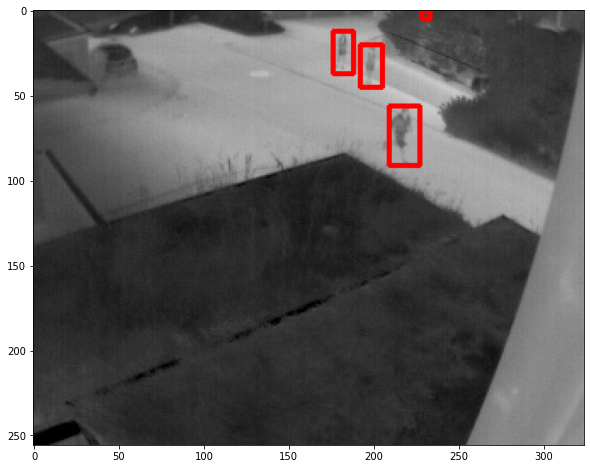

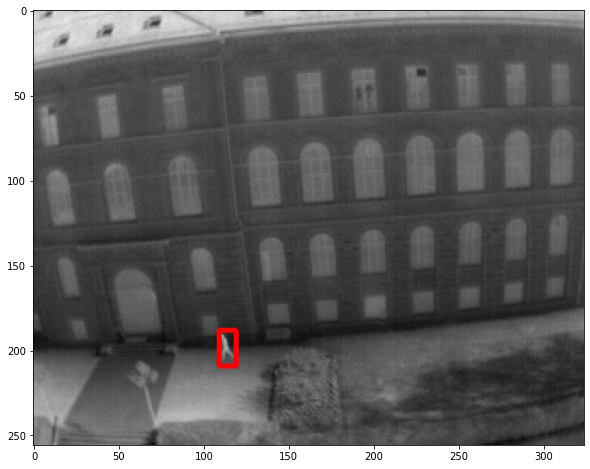

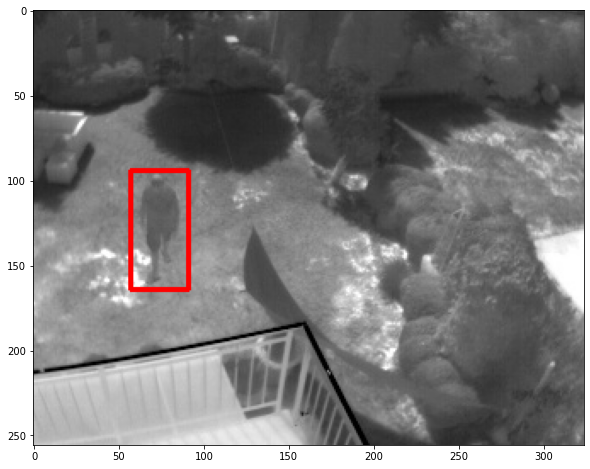

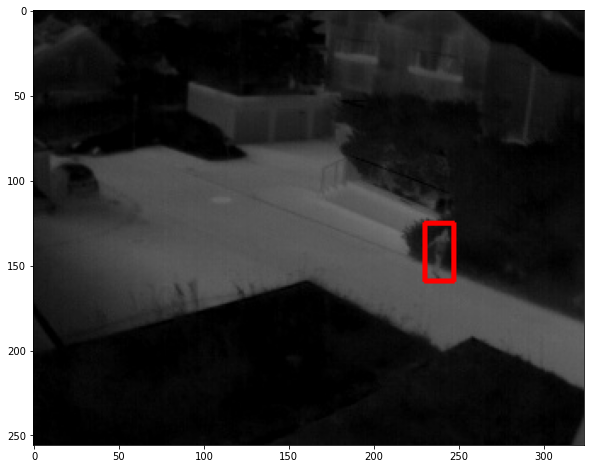

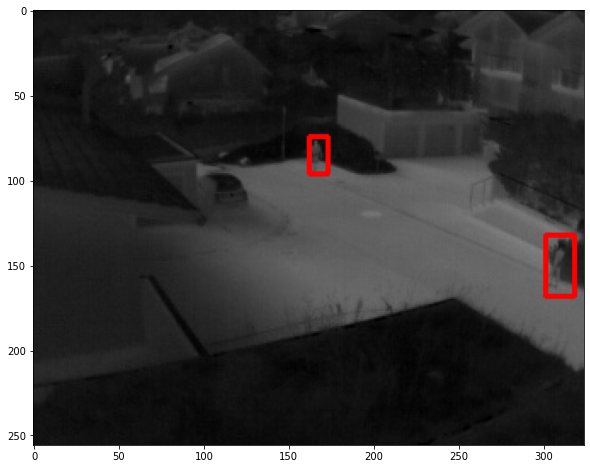

In [8]:
for filename in sample(os.listdir(f'{TRAIN_PROCESSED_DIR}/images'), 5):
    plot_xywhn_annotated_image_from_file(f'{TRAIN_PROCESSED_DIR}/images/{filename.split(".")[0]}.jpg',
                                         f'{TRAIN_PROCESSED_DIR}/labels/{filename.split(".")[0]}.txt')
